COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [1]:
# install dependencies
!rm -r Neural_Networks-101-demo
!git clone -b explanations https://github.com/KiranArun/Neural_Networks-101-demo.git
!python3 /content/Neural_Networks-101-demo/scripts/setup.py helper_funcs

rm: cannot remove 'Neural_Networks-101-demo': No such file or directory
Cloning into 'Neural_Networks-101-demo'...
remote: Counting objects: 383, done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 383 (delta 40), reused 82 (delta 20), pack-reused 271
Receiving objects: 100% (383/383), 9.39 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Getting helper functions...


# MNIST Handwritten Digits Classifier

## Overview

In [0]:
import tensorflow as tf            # import tensorflow, our machine learning library
import numpy as np                 # import numpy, our linear algebra library
import matplotlib.pyplot as plt    # import matplotlib, our graph plotting library

from math import ceil,floor        # import round up and round down functions
import helper_funcs as helper

## Data

In [3]:
# this is the directory where we will keep and external files, eg. data, logs
model_root_dir = '/content/'

# get data
mnist = helper.MNIST_data(model_root_dir+'MNIST_data/')

Download complete.
Save complete.


In [0]:
image_dims = (28,28)  # the image dimensions
input_size = 28**2    # the unstacked image size
num_classes = 10      # the number of classes to predict

### Input Data

In [5]:
# this is the shape of our array of training images
# input data arrays = mnist.<dataset>.images
print('training images array:', mnist.train_images.shape)

training images array: (55000, 784)


### Expected Output Data


In [6]:
# this is the shape of our array of training labels
# input data arrays = mnist.<dataset>.labels
print('training images array:', mnist.train_labels.shape)

training images array: (55000, 10)


### Data Sets

In [7]:
# show data sets
print('training data shape', mnist.train_images.shape)
print('validation data shape', mnist.validation_images.shape)
print('testing data shape', mnist.test_images.shape)

training data shape (55000, 784)
validation data shape (5000, 784)
testing data shape (10000, 784)


## Hyperparameters

In [0]:
# Hyperparams

# number of images to feed in at each step
batch_size = 100

# coeficient to our weight update
learning_rate = 0.1

# number of times to feed in the whole dataset
epochs = 2

# the number of iterations = how many times do we need to input a batch to have inputed the whole training dataset
iterations = ceil(mnist.number_train_samples/batch_size)

# number of neurons in hidden layer
hidden_size = 256

In [0]:
tf.reset_default_graph()

## Placeholders

In [10]:
# input placeholders

# input image
# when dimension = None, it means it's undefined, and will take whatever dimension size we give it
X_placeholder = tf.placeholder(shape=[None, input_size], dtype=tf.float32, name='X_placeholder')

# image labels
Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')


print(X_placeholder)
print(Y_placeholder)

Tensor("X_placeholder:0", shape=(?, 784), dtype=float32)
Tensor("Y_placeholder:0", shape=(?, 10), dtype=int64)


## Variables

In [11]:
# Variables

# First layer Variables
W1 = tf.Variable(np.random.randn(input_size, hidden_size), dtype=tf.float32, name='W1')
b1 = tf.Variable(np.random.randn(hidden_size), dtype=tf.float32, name='b1')

# Second layer Variables
W2 = tf.Variable(np.random.randn(hidden_size, num_classes), dtype=tf.float32, name='W2')
b2 = tf.Variable(np.random.randn(num_classes), dtype=tf.float32, name='b2')

print(W1)
print(b1)

print(W2)
print(b2)

<tf.Variable 'W1:0' shape=(784, 256) dtype=float32_ref>
<tf.Variable 'b1:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'W2:0' shape=(256, 10) dtype=float32_ref>
<tf.Variable 'b2:0' shape=(10,) dtype=float32_ref>


## Forward Pass

In [12]:
# first fully connected layer
# output is our hidden layer
# we matrix multiply (tf.matmul)
# add bias (+ b1)
# then apply activation function (tf.nn.relu)
hidden_layer = tf.nn.relu(tf.matmul(X_placeholder, W1) + b1)

# second fully connected layer
# output is our NN output (predictions)
Y_prediction = tf.matmul(hidden_layer, W2) + b2

print(hidden_layer)
print(Y_prediction)

Tensor("Relu:0", shape=(?, 256), dtype=float32)
Tensor("add_1:0", shape=(?, 10), dtype=float32)


## Loss

In [0]:
# loss function, softmax and cross entropy

# logits = NN output
# labels = expected outputs
# we take the mean so during gradient descent we take the mean step
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder, logits=Y_prediction, name='loss'))

## Gradient Descent

In [0]:
# gradient descent optimizer

# we input the learning rate and set it to minimize the loss value
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

## Calculating Accuracy

In [0]:
# calculating accuracy

# vector of bools on whether the prediction was right or wrong
correct_prediction = tf.equal(tf.argmax(Y_prediction, 1), tf.argmax(Y_placeholder, 1))
# taking the average of the above converted to binary ints (0 for wrong, 1 for right)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# get probability output from softmax
predictions = tf.nn.softmax(Y_prediction)

## Tensorflow Sessions

In [0]:
# Initialize our session and vars
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Training

In [17]:
# initialize empty array to hold losses for each training step
losses = np.array([])

for epoch in range(epochs):
    print('New epoch', str(epoch+1)+'/'+str(epochs))
    for iteration in range(iterations):

        # get batches of training data for current step
        batch_xs, batch_ys = mnist.get_batch(iteration, batch_size)

        # run training step and get loss values to plot later
        # calling optimizer will run the forward pass, the loss function and the pack pass
        # we call the loss function just so we can record it
        _, _loss = sess.run([optimizer, loss], 
                            feed_dict={
                                X_placeholder: batch_xs,
                                Y_placeholder: batch_ys
                            })

        if (iteration+1) % floor(iterations/5) == 0:

            # get accuracy using validation set
            _accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.validation_images,
                                                      Y_placeholder : mnist.validation_labels
                                                     })

            # print current step, batch loss and validation accuracy
            print('step', str(iteration+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')

        # append the loss to the losses array to plot
        losses = np.append(losses, _loss)

New epoch 1/2
step 110/550 loss 9.602563 accuracy 86.18%
step 220/550 loss 2.7450097 accuracy 89.12%
step 330/550 loss 4.910742 accuracy 89.88%
step 440/550 loss 5.692274 accuracy 90.34%
step 550/550 loss 2.039623 accuracy 90.96%
New epoch 2/2
step 110/550 loss 3.511684 accuracy 91.32%
step 220/550 loss 0.6517111 accuracy 91.86%
step 330/550 loss 1.8291947 accuracy 92.52%
step 440/550 loss 3.2666035 accuracy 92.1%
step 550/550 loss 1.4042662 accuracy 92.66%


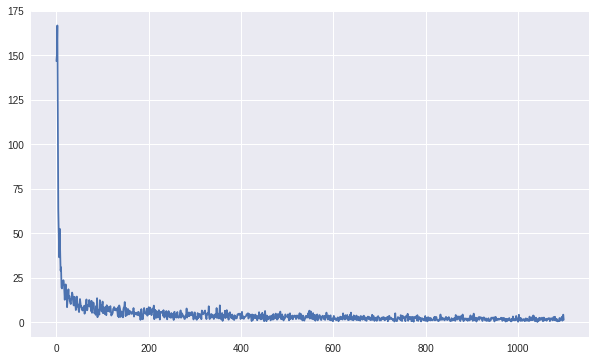

In [18]:
# plot training losses

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(losses)
ax.grid(True)

## Testing

In [19]:
# find accuracy on test set
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test_images,
                                          Y_placeholder : mnist.test_labels
                                         })

print(str(round(100*_accuracy,2))+'%')

91.36%


prediction: 0 answer: 0
0 100.0%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.0%
6 0.0%
7 0.0%
8 0.0%
9 0.0%


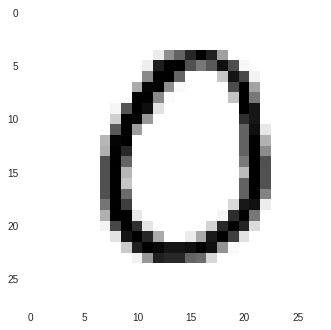

prediction: 6 answer: 6
0 0.0%
1 0.0%
2 0.0%
3 0.0%
4 0.0%
5 0.0%
6 100.0%
7 0.0%
8 0.0%
9 0.0%


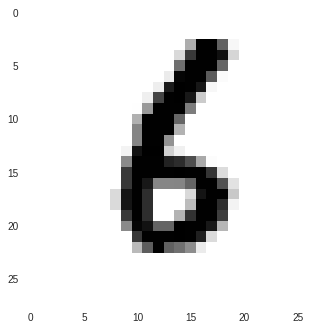

In [20]:
# show test images with prediction probabilities

test_idxs = [1,11]

for test_idx in test_idxs:
    # get input image and corresponding label
    test_x, test_y = mnist.test_images[test_idx], mnist.test_labels[test_idx]

    # make prediction
    _prediction = sess.run(predictions, feed_dict={X_placeholder: test_x.reshape(1,-1)})

    # show prediction and true answer
    print('prediction:', np.argmax(_prediction), 'answer:', np.argmax(test_y))

    # show probabilities for all values
    for i,val in enumerate(_prediction[0]):
        print(i, str(round(100*val,3))+'%')

    # plot test image
    plt.imshow(test_x.reshape(image_dims), cmap='binary')
    plt.grid(False)
    plt.show()